Si può aggiungere una confusion matrix per i link identificati o meno
Potremmo anche aggiungere una descrizione del codice GCN, oppure scriverlo noi con Torch e vedere come performa

# LIBRARIES AND DEFINITION OF ENVIRONMENT

In [2]:
import os.path as osp
import time
import pickle

import torch
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cpu


## FUNCTIONS

In [3]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k):
    """
    Returns k edges and k not edges to be tested.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    shuffle = torch.randperm(edge_label_index.size(1))
    edge_label_index = edge_label_index[:, shuffle]
    edge_label = edge_label[shuffle]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

def corruptNetwork(g, f):
    """
    Corrupts a network by adding/removing edges.
    g: networkx graph
    f: corruption probability
    """
    g = g.copy()

    # Get the list of edges and non-edges of g
    edges = list(g.edges())
    not_edges = list(nx.non_edges(g))

    # Number of edges to be added/removed
    num_corrupted = int(np.floor(f * len(edges)))

    # Randomly select edges to remove
    edges_to_remove = random.sample(edges, num_corrupted)
    g.remove_edges_from(edges_to_remove)

    # Randomly select edges to add
    edges_to_add = random.sample(not_edges, num_corrupted)
    g.add_edges_from(edges_to_add)

    return g

# CLASSES

In [4]:
# define the model structure
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        ## Check cached option for transductive learning
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.reset_parameters()  # Initialize weights

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        # prob_adj = torch.sigmoid(raw_adj)
        return (prob_adj > 0).nonzero(as_tuple=False).t()
    

In [5]:
class GCNTrainer:
    def __init__(self, model, optimizer, criterion, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model.to(device)

    def train(self, train_data, g_train, corrupt=False, corrupt_percentage=0.1):
        self.model.train()
        self.optimizer.zero_grad()

        if corrupt:
            g_corrupted = corruptNetwork(g_train, corrupt_percentage)
            print("The network has been corrupted.")
            train_edge_index_corrupted = graphToEdgelist(g_corrupted)
        else:
            train_edge_index_corrupted = train_data.edge_index

        z = self.model.encode(train_data.x.to(self.device), train_edge_index_corrupted.to(self.device))

        neg_edge_index = negative_sampling(
            edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label, 
                                train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        shuffle = torch.randperm(edge_label_index.size(1))
        edge_label_index = edge_label_index[:, shuffle]
        edge_label = edge_label[shuffle]

        out = self.model.decode(z, edge_label_index.to(self.device)).view(-1)
        loss = self.criterion(out, edge_label.to(self.device))
        loss.backward()
        self.optimizer.step()

        preds = (out > 0.5).float()
        accuracy = (preds == edge_label.to(self.device)).float().mean().item()

        return loss.item(), accuracy

    @torch.no_grad()
    def test(self, data, g_test, corrupt=False, corrupt_percentage=0.1, full_output=False):
        self.model.eval()

        if corrupt:
            g_corrupted = corruptNetwork(g_test, corrupt_percentage)
            test_edge_index_corrupted = graphToEdgelist(g_corrupted)
            print(f"The network has been corrupted with {corrupt_percentage * 100}% corruption.")
        else:
            test_edge_index_corrupted = data.edge_index

        z = self.model.encode(data.x.to(self.device), test_edge_index_corrupted.to(self.device))
        out = self.model.decode(z, data.edge_label_index.to(self.device)).view(-1).sigmoid()

        out_cpu = out.cpu().numpy()
        label_cpu = data.edge_label.cpu().numpy()

        preds = (out > 0.5).float()
        accuracy = (preds.cpu().numpy() == label_cpu).mean()

        auc = roc_auc_score(label_cpu, out_cpu)

        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc

    def train_model(self, train_data, g_train, val_data, g_val, test_data, g_test, epochs=100, early_stopping=False, early_stopping_patience=10, corrupt=False, corrupt_percentage=0.1):
        best_val_auc = 0
        val_history, auc_history, loss_history, train_accuracy_history = [], [], [], []
        best_epoch = 0
        early_stopping_counter = 0

        total_train_time = 0
        total_val_time = 0

        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}")
            train_start_time = time.time()

            loss, train_accuracy = self.train(train_data, g_train, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            train_duration = time.time() - train_start_time
            total_train_time += train_duration
            print(f"Training completed in {train_duration:.4f} seconds.")

            val_start_time = time.time()
            val_acc, val_auc = self.test(val_data, g_val, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            val_duration = time.time() - val_start_time
            total_val_time += val_duration
            print(f"Validation completed in {val_duration:.4f} seconds.")

            val_history.append(val_acc)
            auc_history.append(val_auc)
            loss_history.append(loss)
            train_accuracy_history.append(train_accuracy)

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch = epoch
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_accuracy:.4f}, Val AUC: {val_auc:.4f}, Val ACC: {val_acc:.4f}')

            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                break

        final_test_acc, final_test_auc = self.test(test_data, g_test, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
        print(f'Final Test AUC: {final_test_auc:.4f}')
        print(f'Final Test ACC: {final_test_acc:.4f}')

        print(f"Total training time: {total_train_time:.4f} seconds.")
        print(f"Total validation time: {total_val_time:.4f} seconds.")

        return val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history

# PLANETOID DATASET

## NETWORK EXPLORATION

In [6]:
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

dataset = Planetoid("./data/", name='PubMed', transform=transform)

# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data,
#  val_data, test_data), with
# each element representing the corresponding split.

train_data, val_data, test_data = dataset[0]

g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
g_test = nx.from_edgelist(test_data.edge_index.t().tolist())


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

In [7]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
num_features = dataset.num_features
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.]), Counts: tensor([37676])


In [8]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [9]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [10]:
train_data.x.shape

torch.Size([19717, 500])

## TRAIN, VALIDATION AND AUC CURVES

In [13]:
# Initialize your model, optimizer, and criterion
in_channels = num_features  # Number of input features
hidden_channels = 128 # Number of hidden channels
out_channels = 64 # Number of output features

# Create the model instance
model = Net(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device='cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
val_history, auc_history, loss_history, final_test_auc, final_test_acc, train_accuracy_history = trainer.train_model(
    train_data, 
    g_train,  # Add this argument
    val_data, 
    test_data, 
    epochs=600, 
    early_stopping=False, 
    early_stopping_patience=10,
    corrupt=False,  # Set to True if you want to test corruption
    corrupt_percentage=0.1  # Adjust this value as needed
)

Epoch 1/600
Training completed in 0.2704 seconds.
Validation completed in 0.0630 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8798, Val ACC: 0.5000
Epoch 2/600
Training completed in 0.2558 seconds.
Validation completed in 0.0570 seconds.
Epoch: 002, Loss: 0.6692, Train Acc: 0.5213, Val AUC: 0.8802, Val ACC: 0.5000
Epoch 3/600
Training completed in 0.2270 seconds.
Validation completed in 0.0580 seconds.
Epoch: 003, Loss: 0.6902, Train Acc: 0.6126, Val AUC: 0.8882, Val ACC: 0.5000
Epoch 4/600
Training completed in 0.2350 seconds.
Validation completed in 0.0760 seconds.
Epoch: 004, Loss: 0.6553, Train Acc: 0.7017, Val AUC: 0.8927, Val ACC: 0.5000
Epoch 5/600
Training completed in 0.2680 seconds.
Validation completed in 0.0700 seconds.
Epoch: 005, Loss: 0.6645, Train Acc: 0.5361, Val AUC: 0.8859, Val ACC: 0.5000
Epoch 6/600
Training completed in 0.2670 seconds.
Validation completed in 0.0570 seconds.
Epoch: 006, Loss: 0.6671, Train Acc: 0.5239, Val AUC: 0.8766, Val ACC:

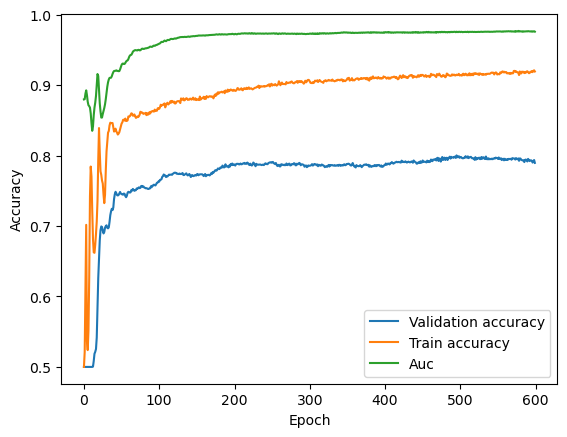

In [14]:
plt.plot(val_history, label="Validation accuracy")
plt.plot(train_accuracy_history, label="Train accuracy")
plt.plot(auc_history, label="Auc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

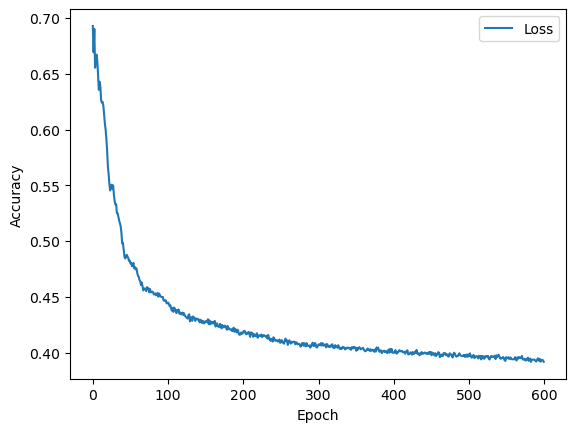

In [15]:
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## PERCENTAGE OF TRAINING DATA

In [11]:
# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

# Define percentages
percentages = np.linspace(0.1, 0.9, 9)

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1 - 0.05 - i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./data/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        g_val = nx.from_edgelist(val_data.edge_index.t().tolist())
        g_test = nx.from_edgelist(test_data.edge_index.t().tolist())
        
        model = Net(dataset.num_features, 128, 64).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and get results
        # Assicurati di passare g_val e g_test alla funzione train_model
        _, _, _, final_test_auc, final_test_acc, _ = trainer.train_model(
        train_data=train_data,
        g_train=g_train,
        val_data=val_data,
        g_val=g_val,
        test_data=test_data,
        g_test=g_test,
        epochs=300
    )


        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

Epoch 1/300
Training completed in 0.0560 seconds.
Validation completed in 0.0130 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7381, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0290 seconds.
Validation completed in 0.0140 seconds.
Epoch: 002, Loss: 0.6925, Train Acc: 0.5000, Val AUC: 0.6938, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0270 seconds.
Validation completed in 0.0110 seconds.
Epoch: 003, Loss: 0.6914, Train Acc: 0.5000, Val AUC: 0.6748, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0270 seconds.
Validation completed in 0.0120 seconds.
Epoch: 004, Loss: 0.6901, Train Acc: 0.5000, Val AUC: 0.6640, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 005, Loss: 0.6891, Train Acc: 0.5030, Val AUC: 0.6422, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 006, Loss: 0.6861, Train Acc: 0.5006, Val AUC: 0.6276, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0470 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7368, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0360 seconds.
Validation completed in 0.0140 seconds.
Epoch: 002, Loss: 0.6924, Train Acc: 0.5000, Val AUC: 0.6876, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0300 seconds.
Validation completed in 0.0120 seconds.
Epoch: 003, Loss: 0.6914, Train Acc: 0.5000, Val AUC: 0.6720, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0280 seconds.
Validation completed in 0.0120 seconds.
Epoch: 004, Loss: 0.6901, Train Acc: 0.5000, Val AUC: 0.6645, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0270 seconds.
Validation completed in 0.0120 seconds.
Epoch: 005, Loss: 0.6896, Train Acc: 0.5051, Val AUC: 0.6475, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0270 seconds.
Validation completed in 0.0120 seconds.
Epoch: 006, Loss: 0.6872, Train Acc: 0.5008, Val AUC: 0.6321, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0400 seconds.
Validation completed in 0.0130 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7257, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0300 seconds.
Validation completed in 0.0130 seconds.
Epoch: 002, Loss: 0.6924, Train Acc: 0.5000, Val AUC: 0.6885, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0290 seconds.
Validation completed in 0.0120 seconds.
Epoch: 003, Loss: 0.6911, Train Acc: 0.5000, Val AUC: 0.6794, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0290 seconds.
Validation completed in 0.0120 seconds.
Epoch: 004, Loss: 0.6900, Train Acc: 0.5000, Val AUC: 0.6715, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0300 seconds.
Validation completed in 0.0130 seconds.
Epoch: 005, Loss: 0.6884, Train Acc: 0.5027, Val AUC: 0.6547, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0320 seconds.
Validation completed in 0.0136 seconds.
Epoch: 006, Loss: 0.6854, Train Acc: 0.5011, Val AUC: 0.6461, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0360 seconds.
Validation completed in 0.0150 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7301, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0290 seconds.
Validation completed in 0.0130 seconds.
Epoch: 002, Loss: 0.6925, Train Acc: 0.5000, Val AUC: 0.7032, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0310 seconds.
Validation completed in 0.0120 seconds.
Epoch: 003, Loss: 0.6916, Train Acc: 0.5000, Val AUC: 0.6884, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 004, Loss: 0.6906, Train Acc: 0.5000, Val AUC: 0.6815, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 005, Loss: 0.6900, Train Acc: 0.5007, Val AUC: 0.6638, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 006, Loss: 0.6878, Train Acc: 0.5000, Val AUC: 0.6512, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0330 seconds.
Validation completed in 0.0140 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7578, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 002, Loss: 0.6925, Train Acc: 0.5000, Val AUC: 0.6948, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0270 seconds.
Validation completed in 0.0110 seconds.
Epoch: 003, Loss: 0.6917, Train Acc: 0.5000, Val AUC: 0.6707, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0260 seconds.
Validation completed in 0.0110 seconds.
Epoch: 004, Loss: 0.6907, Train Acc: 0.5000, Val AUC: 0.6625, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0260 seconds.
Validation completed in 0.0120 seconds.
Epoch: 005, Loss: 0.6898, Train Acc: 0.5006, Val AUC: 0.6467, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0270 seconds.
Validation completed in 0.0120 seconds.
Epoch: 006, Loss: 0.6877, Train Acc: 0.5002, Val AUC: 0.6367, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Training completed in 0.0450 seconds.
Validation completed in 0.0140 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7548, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0350 seconds.
Validation completed in 0.0130 seconds.
Epoch: 002, Loss: 0.6923, Train Acc: 0.5000, Val AUC: 0.7605, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0360 seconds.
Validation completed in 0.0140 seconds.
Epoch: 003, Loss: 0.6894, Train Acc: 0.5000, Val AUC: 0.7532, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0340 seconds.
Validation completed in 0.0130 seconds.
Epoch: 004, Loss: 0.6866, Train Acc: 0.5078, Val AUC: 0.7488, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0340 seconds.
Validation completed in 0.0140 seconds.
Epoch: 005, Loss: 0.6860, Train Acc: 0.5750, Val AUC: 0.7252, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0330 seconds.
Validation completed in 0.0130 seconds.
Epoch: 006, Loss: 0.6813, Train Acc: 0.5162, Val AUC: 0.7013, Val ACC: 0.5000
Epoc

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Training completed in 0.0530 seconds.
Validation completed in 0.0140 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7281, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0350 seconds.
Validation completed in 0.0130 seconds.
Epoch: 002, Loss: 0.6919, Train Acc: 0.5000, Val AUC: 0.7375, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0350 seconds.
Validation completed in 0.0140 seconds.
Epoch: 003, Loss: 0.6887, Train Acc: 0.5000, Val AUC: 0.7358, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0350 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6867, Train Acc: 0.5248, Val AUC: 0.7216, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0350 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6838, Train Acc: 0.5431, Val AUC: 0.6935, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0360 seconds.
Validation completed in 0.0140 seconds.
Epoch: 006, Loss: 0.6794, Train Acc: 0.5267, Val AUC: 0.6762, Val ACC: 0.5000
Epoc

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0540 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7708, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0340 seconds.
Validation completed in 0.0130 seconds.
Epoch: 002, Loss: 0.6924, Train Acc: 0.5000, Val AUC: 0.7539, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0340 seconds.
Validation completed in 0.0140 seconds.
Epoch: 003, Loss: 0.6898, Train Acc: 0.5000, Val AUC: 0.7396, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0340 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6870, Train Acc: 0.5061, Val AUC: 0.7342, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0360 seconds.
Validation completed in 0.0130 seconds.
Epoch: 005, Loss: 0.6868, Train Acc: 0.5691, Val AUC: 0.7168, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0350 seconds.
Validation completed in 0.0130 seconds.
Epoch: 006, Loss: 0.6825, Train Acc: 0.5106, Val AUC: 0.6945, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0510 seconds.
Validation completed in 0.0140 seconds.
Epoch: 001, Loss: 0.6930, Train Acc: 0.5000, Val AUC: 0.7509, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0340 seconds.
Validation completed in 0.0120 seconds.
Epoch: 002, Loss: 0.6923, Train Acc: 0.5000, Val AUC: 0.7496, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0320 seconds.
Validation completed in 0.0120 seconds.
Epoch: 003, Loss: 0.6892, Train Acc: 0.5000, Val AUC: 0.7478, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0310 seconds.
Validation completed in 0.0130 seconds.
Epoch: 004, Loss: 0.6859, Train Acc: 0.5127, Val AUC: 0.7429, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0320 seconds.
Validation completed in 0.0120 seconds.
Epoch: 005, Loss: 0.6854, Train Acc: 0.5852, Val AUC: 0.7198, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0320 seconds.
Validation completed in 0.0130 seconds.
Epoch: 006, Loss: 0.6808, Train Acc: 0.5160, Val AUC: 0.6975, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Training completed in 0.0480 seconds.
Validation completed in 0.0150 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7823, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0330 seconds.
Validation completed in 0.0120 seconds.
Epoch: 002, Loss: 0.6922, Train Acc: 0.5000, Val AUC: 0.7685, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0320 seconds.
Validation completed in 0.0120 seconds.
Epoch: 003, Loss: 0.6894, Train Acc: 0.5000, Val AUC: 0.7593, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0310 seconds.
Validation completed in 0.0130 seconds.
Epoch: 004, Loss: 0.6863, Train Acc: 0.5107, Val AUC: 0.7552, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0320 seconds.
Validation completed in 0.0130 seconds.
Epoch: 005, Loss: 0.6848, Train Acc: 0.5699, Val AUC: 0.7316, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0320 seconds.
Validation completed in 0.0130 seconds.
Epoch: 006, Loss: 0.6807, Train Acc: 0.5146, Val AUC: 0.7084, Val ACC: 0.5000
Epoc

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Training completed in 0.0680 seconds.
Validation completed in 0.0150 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7870, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0400 seconds.
Validation completed in 0.0150 seconds.
Epoch: 002, Loss: 0.6916, Train Acc: 0.5000, Val AUC: 0.7883, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0400 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6864, Train Acc: 0.5002, Val AUC: 0.7840, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0400 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6833, Train Acc: 0.5946, Val AUC: 0.7785, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0400 seconds.
Validation completed in 0.0140 seconds.
Epoch: 005, Loss: 0.6789, Train Acc: 0.5946, Val AUC: 0.7572, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0400 seconds.
Validation completed in 0.0140 seconds.
Epoch: 006, Loss: 0.6751, Train Acc: 0.5521, Val AUC: 0.7370, Val ACC: 0.5000
Epoc

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0580 seconds.
Validation completed in 0.0140 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7797, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0400 seconds.
Validation completed in 0.0150 seconds.
Epoch: 002, Loss: 0.6914, Train Acc: 0.5000, Val AUC: 0.7929, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0390 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6865, Train Acc: 0.5000, Val AUC: 0.7925, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0380 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6830, Train Acc: 0.5862, Val AUC: 0.7824, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0380 seconds.
Validation completed in 0.0140 seconds.
Epoch: 005, Loss: 0.6794, Train Acc: 0.6176, Val AUC: 0.7558, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0370 seconds.
Validation completed in 0.0140 seconds.
Epoch: 006, Loss: 0.6748, Train Acc: 0.5587, Val AUC: 0.7348, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0550 seconds.
Validation completed in 0.0150 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7969, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0380 seconds.
Validation completed in 0.0140 seconds.
Epoch: 002, Loss: 0.6917, Train Acc: 0.5000, Val AUC: 0.7937, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0390 seconds.
Validation completed in 0.0130 seconds.
Epoch: 003, Loss: 0.6872, Train Acc: 0.5000, Val AUC: 0.7879, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0380 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6826, Train Acc: 0.5448, Val AUC: 0.7830, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0390 seconds.
Validation completed in 0.0130 seconds.
Epoch: 005, Loss: 0.6821, Train Acc: 0.6834, Val AUC: 0.7625, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0370 seconds.
Validation completed in 0.0140 seconds.
Epoch: 006, Loss: 0.6757, Train Acc: 0.5567, Val AUC: 0.7343, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0606 seconds.
Validation completed in 0.0142 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7970, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0410 seconds.
Validation completed in 0.0140 seconds.
Epoch: 002, Loss: 0.6915, Train Acc: 0.5000, Val AUC: 0.7979, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0361 seconds.
Validation completed in 0.0140 seconds.
Epoch: 003, Loss: 0.6867, Train Acc: 0.5001, Val AUC: 0.7923, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0380 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6841, Train Acc: 0.5887, Val AUC: 0.7914, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0380 seconds.
Validation completed in 0.0130 seconds.
Epoch: 005, Loss: 0.6799, Train Acc: 0.5758, Val AUC: 0.7736, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0380 seconds.
Validation completed in 0.0130 seconds.
Epoch: 006, Loss: 0.6763, Train Acc: 0.5453, Val AUC: 0.7563, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0570 seconds.
Validation completed in 0.0150 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.7963, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0400 seconds.
Validation completed in 0.0140 seconds.
Epoch: 002, Loss: 0.6918, Train Acc: 0.5000, Val AUC: 0.8002, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0360 seconds.
Validation completed in 0.0140 seconds.
Epoch: 003, Loss: 0.6874, Train Acc: 0.5001, Val AUC: 0.7966, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0370 seconds.
Validation completed in 0.0140 seconds.
Epoch: 004, Loss: 0.6826, Train Acc: 0.5535, Val AUC: 0.7952, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0370 seconds.
Validation completed in 0.0140 seconds.
Epoch: 005, Loss: 0.6816, Train Acc: 0.6654, Val AUC: 0.7781, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0400 seconds.
Validation completed in 0.0140 seconds.
Epoch: 006, Loss: 0.6764, Train Acc: 0.5397, Val AUC: 0.7539, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0800 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8107, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0470 seconds.
Validation completed in 0.0150 seconds.
Epoch: 002, Loss: 0.6906, Train Acc: 0.5000, Val AUC: 0.8256, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0470 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6825, Train Acc: 0.5015, Val AUC: 0.8259, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0470 seconds.
Validation completed in 0.0150 seconds.
Epoch: 004, Loss: 0.6798, Train Acc: 0.7228, Val AUC: 0.8127, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0440 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6733, Train Acc: 0.6398, Val AUC: 0.7838, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0460 seconds.
Validation completed in 0.0157 seconds.
Epoch: 006, Loss: 0.6694, Train Acc: 0.5858, Val AUC: 0.7611, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0660 seconds.
Validation completed in 0.0170 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8174, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0480 seconds.
Validation completed in 0.0160 seconds.
Epoch: 002, Loss: 0.6912, Train Acc: 0.5000, Val AUC: 0.8220, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0470 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6849, Train Acc: 0.5003, Val AUC: 0.8210, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0440 seconds.
Validation completed in 0.0150 seconds.
Epoch: 004, Loss: 0.6809, Train Acc: 0.6695, Val AUC: 0.8199, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0430 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6754, Train Acc: 0.6294, Val AUC: 0.8050, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0450 seconds.
Validation completed in 0.0150 seconds.
Epoch: 006, Loss: 0.6715, Train Acc: 0.5761, Val AUC: 0.7906, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0559 seconds.
Validation completed in 0.0161 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8163, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0441 seconds.
Validation completed in 0.0150 seconds.
Epoch: 002, Loss: 0.6909, Train Acc: 0.5000, Val AUC: 0.8197, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0440 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6841, Train Acc: 0.5005, Val AUC: 0.8187, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0450 seconds.
Validation completed in 0.0150 seconds.
Epoch: 004, Loss: 0.6793, Train Acc: 0.6792, Val AUC: 0.8136, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0450 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6749, Train Acc: 0.6711, Val AUC: 0.7931, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0430 seconds.
Validation completed in 0.0150 seconds.
Epoch: 006, Loss: 0.6706, Train Acc: 0.5859, Val AUC: 0.7730, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8337, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0480 seconds.
Validation completed in 0.0150 seconds.
Epoch: 002, Loss: 0.6912, Train Acc: 0.5000, Val AUC: 0.8277, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0480 seconds.
Validation completed in 0.0150 seconds.
Epoch: 003, Loss: 0.6849, Train Acc: 0.5005, Val AUC: 0.8249, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0450 seconds.
Validation completed in 0.0150 seconds.
Epoch: 004, Loss: 0.6807, Train Acc: 0.6566, Val AUC: 0.8225, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0450 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6763, Train Acc: 0.6381, Val AUC: 0.8040, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0440 seconds.
Validation completed in 0.0150 seconds.
Epoch: 006, Loss: 0.6721, Train Acc: 0.5677, Val AUC: 0.7851, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0590 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8173, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0490 seconds.
Validation completed in 0.0170 seconds.
Epoch: 002, Loss: 0.6909, Train Acc: 0.5000, Val AUC: 0.8265, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0480 seconds.
Validation completed in 0.0170 seconds.
Epoch: 003, Loss: 0.6836, Train Acc: 0.5010, Val AUC: 0.8268, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0500 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6811, Train Acc: 0.7375, Val AUC: 0.8247, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0500 seconds.
Validation completed in 0.0160 seconds.
Epoch: 005, Loss: 0.6745, Train Acc: 0.6188, Val AUC: 0.8073, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0490 seconds.
Validation completed in 0.0160 seconds.
Epoch: 006, Loss: 0.6715, Train Acc: 0.5677, Val AUC: 0.7901, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8489, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0550 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6903, Train Acc: 0.5000, Val AUC: 0.8516, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0560 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6814, Train Acc: 0.5026, Val AUC: 0.8527, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0550 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6793, Train Acc: 0.7938, Val AUC: 0.8552, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 005, Loss: 0.6707, Train Acc: 0.6388, Val AUC: 0.8439, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0540 seconds.
Validation completed in 0.0170 seconds.
Epoch: 006, Loss: 0.6685, Train Acc: 0.5785, Val AUC: 0.8301, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0650 seconds.
Validation completed in 0.0170 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8536, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 002, Loss: 0.6904, Train Acc: 0.5000, Val AUC: 0.8560, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 003, Loss: 0.6811, Train Acc: 0.5025, Val AUC: 0.8556, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0530 seconds.
Validation completed in 0.0160 seconds.
Epoch: 004, Loss: 0.6783, Train Acc: 0.7938, Val AUC: 0.8532, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0560 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6704, Train Acc: 0.6563, Val AUC: 0.8371, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0540 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6675, Train Acc: 0.5901, Val AUC: 0.8214, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0580 seconds.
Validation completed in 0.0170 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8369, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 002, Loss: 0.6904, Train Acc: 0.5000, Val AUC: 0.8354, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0530 seconds.
Validation completed in 0.0160 seconds.
Epoch: 003, Loss: 0.6812, Train Acc: 0.5023, Val AUC: 0.8342, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0560 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6783, Train Acc: 0.7947, Val AUC: 0.8322, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0530 seconds.
Validation completed in 0.0160 seconds.
Epoch: 005, Loss: 0.6709, Train Acc: 0.6619, Val AUC: 0.8166, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0530 seconds.
Validation completed in 0.0160 seconds.
Epoch: 006, Loss: 0.6679, Train Acc: 0.5854, Val AUC: 0.8007, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0650 seconds.
Validation completed in 0.0170 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8389, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0540 seconds.
Validation completed in 0.0170 seconds.
Epoch: 002, Loss: 0.6900, Train Acc: 0.5000, Val AUC: 0.8415, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0560 seconds.
Validation completed in 0.0248 seconds.
Epoch: 003, Loss: 0.6800, Train Acc: 0.5041, Val AUC: 0.8410, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0558 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6803, Train Acc: 0.7878, Val AUC: 0.8356, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0541 seconds.
Validation completed in 0.0170 seconds.
Epoch: 005, Loss: 0.6705, Train Acc: 0.6353, Val AUC: 0.8144, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0540 seconds.
Validation completed in 0.0170 seconds.
Epoch: 006, Loss: 0.6690, Train Acc: 0.5639, Val AUC: 0.7968, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8474, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0550 seconds.
Validation completed in 0.0170 seconds.
Epoch: 002, Loss: 0.6908, Train Acc: 0.5000, Val AUC: 0.8476, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 003, Loss: 0.6822, Train Acc: 0.5012, Val AUC: 0.8471, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0530 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6766, Train Acc: 0.7531, Val AUC: 0.8466, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0540 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6716, Train Acc: 0.7206, Val AUC: 0.8348, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0550 seconds.
Validation completed in 0.0170 seconds.
Epoch: 006, Loss: 0.6674, Train Acc: 0.6007, Val AUC: 0.8186, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0690 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8581, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0600 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6891, Train Acc: 0.5000, Val AUC: 0.8598, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0620 seconds.
Validation completed in 0.0170 seconds.
Epoch: 003, Loss: 0.6762, Train Acc: 0.5111, Val AUC: 0.8602, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6777, Train Acc: 0.7745, Val AUC: 0.8587, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6644, Train Acc: 0.7080, Val AUC: 0.8471, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0720 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6640, Train Acc: 0.5926, Val AUC: 0.8333, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0680 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8607, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0610 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6890, Train Acc: 0.5000, Val AUC: 0.8625, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0630 seconds.
Validation completed in 0.0240 seconds.
Epoch: 003, Loss: 0.6760, Train Acc: 0.5126, Val AUC: 0.8632, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0590 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6793, Train Acc: 0.7675, Val AUC: 0.8646, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0590 seconds.
Validation completed in 0.0170 seconds.
Epoch: 005, Loss: 0.6652, Train Acc: 0.6962, Val AUC: 0.8543, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0580 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6647, Train Acc: 0.5808, Val AUC: 0.8405, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0720 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8575, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0590 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6897, Train Acc: 0.5000, Val AUC: 0.8584, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0620 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6782, Train Acc: 0.5057, Val AUC: 0.8598, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0590 seconds.
Validation completed in 0.0170 seconds.
Epoch: 004, Loss: 0.6762, Train Acc: 0.8045, Val AUC: 0.8608, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0590 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6660, Train Acc: 0.7027, Val AUC: 0.8510, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0590 seconds.
Validation completed in 0.0170 seconds.
Epoch: 006, Loss: 0.6641, Train Acc: 0.5987, Val AUC: 0.8378, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0680 seconds.
Validation completed in 0.0210 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8626, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0620 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6908, Train Acc: 0.5000, Val AUC: 0.8556, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6821, Train Acc: 0.5011, Val AUC: 0.8542, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6713, Train Acc: 0.7141, Val AUC: 0.8561, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0600 seconds.
Validation completed in 0.0170 seconds.
Epoch: 005, Loss: 0.6763, Train Acc: 0.7784, Val AUC: 0.8518, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0600 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6630, Train Acc: 0.6397, Val AUC: 0.8366, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8517, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0610 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6900, Train Acc: 0.5000, Val AUC: 0.8529, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0580 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6794, Train Acc: 0.5041, Val AUC: 0.8538, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0580 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6751, Train Acc: 0.8090, Val AUC: 0.8561, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0590 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6673, Train Acc: 0.7187, Val AUC: 0.8478, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0660 seconds.
Validation completed in 0.0196 seconds.
Epoch: 006, Loss: 0.6638, Train Acc: 0.6082, Val AUC: 0.8359, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0871 seconds.
Validation completed in 0.0198 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8743, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0641 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6888, Train Acc: 0.5000, Val AUC: 0.8754, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6738, Train Acc: 0.5152, Val AUC: 0.8756, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0640 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6770, Train Acc: 0.7438, Val AUC: 0.8766, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0640 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6615, Train Acc: 0.7437, Val AUC: 0.8698, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6616, Train Acc: 0.5943, Val AUC: 0.8592, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0740 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8670, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6885, Train Acc: 0.5000, Val AUC: 0.8686, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0650 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6736, Train Acc: 0.5176, Val AUC: 0.8697, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6762, Train Acc: 0.7557, Val AUC: 0.8708, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0640 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6611, Train Acc: 0.7550, Val AUC: 0.8636, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6608, Train Acc: 0.6047, Val AUC: 0.8526, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0810 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8762, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0650 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6897, Train Acc: 0.5000, Val AUC: 0.8754, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6770, Train Acc: 0.5056, Val AUC: 0.8757, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6691, Train Acc: 0.8254, Val AUC: 0.8758, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0650 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6631, Train Acc: 0.8127, Val AUC: 0.8676, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6582, Train Acc: 0.6548, Val AUC: 0.8551, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0730 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8851, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6892, Train Acc: 0.5000, Val AUC: 0.8834, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0640 seconds.
Validation completed in 0.0210 seconds.
Epoch: 003, Loss: 0.6760, Train Acc: 0.5078, Val AUC: 0.8831, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0630 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6704, Train Acc: 0.8235, Val AUC: 0.8835, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0630 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6631, Train Acc: 0.7988, Val AUC: 0.8762, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0640 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6586, Train Acc: 0.6452, Val AUC: 0.8653, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.1040 seconds.
Validation completed in 0.0224 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8851, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6893, Train Acc: 0.5000, Val AUC: 0.8842, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0630 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6757, Train Acc: 0.5092, Val AUC: 0.8848, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0650 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6749, Train Acc: 0.7851, Val AUC: 0.8864, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0640 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6625, Train Acc: 0.7461, Val AUC: 0.8797, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0640 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6613, Train Acc: 0.6083, Val AUC: 0.8693, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0880 seconds.
Validation completed in 0.0210 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8912, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6885, Train Acc: 0.5000, Val AUC: 0.8899, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6716, Train Acc: 0.5186, Val AUC: 0.8900, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0670 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6711, Train Acc: 0.7646, Val AUC: 0.8917, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6568, Train Acc: 0.8021, Val AUC: 0.8874, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6559, Train Acc: 0.6420, Val AUC: 0.8796, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0850 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8910, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6888, Train Acc: 0.5000, Val AUC: 0.8882, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0670 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6731, Train Acc: 0.5122, Val AUC: 0.8880, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6658, Train Acc: 0.8254, Val AUC: 0.8895, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6577, Train Acc: 0.8329, Val AUC: 0.8854, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6531, Train Acc: 0.6877, Val AUC: 0.8773, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0830 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8853, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0720 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6892, Train Acc: 0.5000, Val AUC: 0.8814, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6750, Train Acc: 0.5069, Val AUC: 0.8815, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0720 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6649, Train Acc: 0.8347, Val AUC: 0.8831, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6606, Train Acc: 0.8312, Val AUC: 0.8796, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0710 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6535, Train Acc: 0.6872, Val AUC: 0.8715, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.1080 seconds.
Validation completed in 0.0203 seconds.
Epoch: 001, Loss: 0.6927, Train Acc: 0.5000, Val AUC: 0.8879, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0698 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6874, Train Acc: 0.5000, Val AUC: 0.8856, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0680 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6684, Train Acc: 0.5373, Val AUC: 0.8854, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 004, Loss: 0.6792, Train Acc: 0.6963, Val AUC: 0.8865, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0660 seconds.
Validation completed in 0.0180 seconds.
Epoch: 005, Loss: 0.6562, Train Acc: 0.7925, Val AUC: 0.8815, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6588, Train Acc: 0.6015, Val AUC: 0.8717, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0850 seconds.
Validation completed in 0.0190 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8959, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0670 seconds.
Validation completed in 0.0180 seconds.
Epoch: 002, Loss: 0.6892, Train Acc: 0.5000, Val AUC: 0.8925, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0680 seconds.
Validation completed in 0.0180 seconds.
Epoch: 003, Loss: 0.6747, Train Acc: 0.5086, Val AUC: 0.8926, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0680 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6684, Train Acc: 0.8220, Val AUC: 0.8950, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0660 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6591, Train Acc: 0.8173, Val AUC: 0.8920, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0690 seconds.
Validation completed in 0.0180 seconds.
Epoch: 006, Loss: 0.6553, Train Acc: 0.6651, Val AUC: 0.8853, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0842 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8970, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 002, Loss: 0.6884, Train Acc: 0.5000, Val AUC: 0.8933, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0760 seconds.
Validation completed in 0.0210 seconds.
Epoch: 003, Loss: 0.6706, Train Acc: 0.5178, Val AUC: 0.8937, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0750 seconds.
Validation completed in 0.0210 seconds.
Epoch: 004, Loss: 0.6645, Train Acc: 0.8080, Val AUC: 0.8951, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0750 seconds.
Validation completed in 0.0210 seconds.
Epoch: 005, Loss: 0.6536, Train Acc: 0.8365, Val AUC: 0.8919, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 006, Loss: 0.6498, Train Acc: 0.6955, Val AUC: 0.8856, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0860 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8939, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 002, Loss: 0.6884, Train Acc: 0.5000, Val AUC: 0.8920, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 003, Loss: 0.6700, Train Acc: 0.5192, Val AUC: 0.8928, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0760 seconds.
Validation completed in 0.0200 seconds.
Epoch: 004, Loss: 0.6662, Train Acc: 0.7925, Val AUC: 0.8951, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 005, Loss: 0.6534, Train Acc: 0.8365, Val AUC: 0.8935, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 006, Loss: 0.6508, Train Acc: 0.6878, Val AUC: 0.8887, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0900 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.9030, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 002, Loss: 0.6888, Train Acc: 0.5000, Val AUC: 0.8998, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0730 seconds.
Validation completed in 0.0210 seconds.
Epoch: 003, Loss: 0.6719, Train Acc: 0.5120, Val AUC: 0.8999, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0750 seconds.
Validation completed in 0.0200 seconds.
Epoch: 004, Loss: 0.6647, Train Acc: 0.8181, Val AUC: 0.9022, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0760 seconds.
Validation completed in 0.0210 seconds.
Epoch: 005, Loss: 0.6545, Train Acc: 0.8403, Val AUC: 0.8997, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0760 seconds.
Validation completed in 0.0210 seconds.
Epoch: 006, Loss: 0.6507, Train Acc: 0.7067, Val AUC: 0.8934, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0880 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.9005, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0760 seconds.
Validation completed in 0.0190 seconds.
Epoch: 002, Loss: 0.6887, Train Acc: 0.5000, Val AUC: 0.8975, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0780 seconds.
Validation completed in 0.0200 seconds.
Epoch: 003, Loss: 0.6719, Train Acc: 0.5130, Val AUC: 0.8982, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0750 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6633, Train Acc: 0.8227, Val AUC: 0.9002, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0760 seconds.
Validation completed in 0.0200 seconds.
Epoch: 005, Loss: 0.6551, Train Acc: 0.8406, Val AUC: 0.8979, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0750 seconds.
Validation completed in 0.0210 seconds.
Epoch: 006, Loss: 0.6500, Train Acc: 0.7113, Val AUC: 0.8926, Val ACC:

c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0950 seconds.
Validation completed in 0.0220 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.8930, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0870 seconds.
Validation completed in 0.0240 seconds.
Epoch: 002, Loss: 0.6882, Train Acc: 0.5000, Val AUC: 0.8911, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0790 seconds.
Validation completed in 0.0210 seconds.
Epoch: 003, Loss: 0.6693, Train Acc: 0.5234, Val AUC: 0.8917, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0781 seconds.
Validation completed in 0.0195 seconds.
Epoch: 004, Loss: 0.6673, Train Acc: 0.7821, Val AUC: 0.8938, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0720 seconds.
Validation completed in 0.0210 seconds.
Epoch: 005, Loss: 0.6534, Train Acc: 0.8349, Val AUC: 0.8915, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0740 seconds.
Validation completed in 0.0200 seconds.
Epoch: 006, Loss: 0.6516, Train Acc: 0.6771, Val AUC: 0.8856, Val ACC:

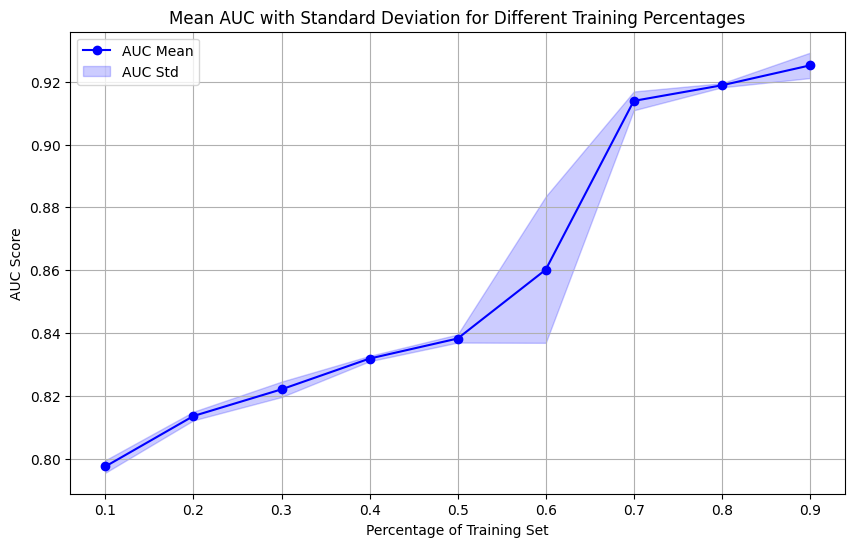

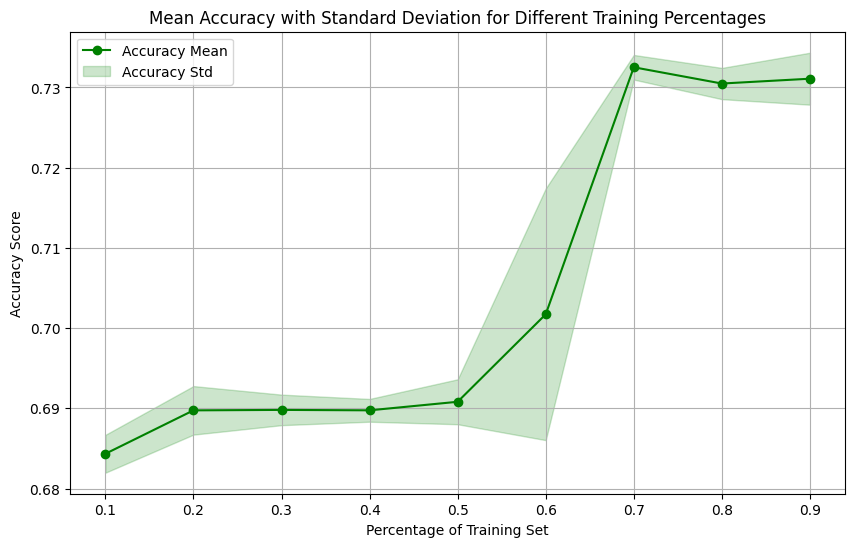

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2, label='AUC Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('AUC Score')
plt.title('Mean AUC with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2, label='Accuracy Std')
plt.xlabel('Percentage of Training Set')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Training Percentages')
plt.grid(True)
plt.legend()

In [15]:
# Save results, model structure, and percentages to a pickle file
results = {
    'test_accuracy_auc_mean': test_accuracy_auc_mean,
    'test_accuracy_auc_std': test_accuracy_auc_std,
    'test_accuracy_acc_mean': test_accuracy_acc_mean,
    'test_accuracy_acc_std': test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': percentages.tolist()  # Convert numpy array to list for serialization
}

with open('results_and_model_class.pkl', 'wb') as f:
    pickle.dump(results, f)

## PERCENTAGE OF FEATURES

In [20]:
# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

# Define percentages of features to use
feature_percentages = np.linspace(0.1, 0.9, 9)  # e.g., 10%, 20%, ..., 90% of features

# Fixed train, validation, and test split once
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # Fixed sizes
                      add_negative_train_samples=False),
])

dataset = Planetoid("./data/", name='PubMed', transform=transform)
train_data, val_data, test_data = dataset[0]

# Original number of features
num_features = train_data.x.size(1)  # Assuming `x` is the node feature matrix (N x F)
for perc in feature_percentages:
    auc_scores = []
    acc_scores = []

    # Determine the number of features to use for this percentage
    num_features_to_use = min(int(perc * num_features), num_features)  # Ensure it does not exceed actual number of features

    for _ in range(5):  # Repeat 5 times to average
        # Shuffle and select a percentage of features
        selected_features_idx = np.random.permutation(num_features)[:num_features_to_use]


        
        # Create copies of the data and apply the selected features to the dataset
        train_data_copy = train_data.clone()
        val_data_copy = val_data.clone()
        test_data_copy = test_data.clone()

        # Apply the selected features to the dataset
        train_data_copy.x = train_data_copy.x[:, selected_features_idx]
        val_data_copy.x = val_data_copy.x[:, selected_features_idx]
        test_data_copy.x = test_data_copy.x[:, selected_features_idx]

        # Initialize model, optimizer, and criterion
        model = Net(num_features_to_use, 128, 64).to(device)  # Update input size
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and evaluate
        _, _, _, final_test_auc, final_test_acc, _ = trainer.train_model(
            train_data=train_data_copy,
            g_train=g_train,
            val_data=val_data_copy,
            g_val=g_val,
            test_data=test_data_copy,
            g_test=g_test,
            epochs=300
        )

        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)

    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if os

Epoch 1/300
Training completed in 0.0690 seconds.
Validation completed in 0.0160 seconds.
Epoch: 001, Loss: 0.6929, Train Acc: 0.5000, Val AUC: 0.8995, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0620 seconds.
Validation completed in 0.0160 seconds.
Epoch: 002, Loss: 0.6889, Train Acc: 0.5000, Val AUC: 0.8963, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0650 seconds.
Validation completed in 0.0160 seconds.
Epoch: 003, Loss: 0.6759, Train Acc: 0.5055, Val AUC: 0.8965, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0630 seconds.
Validation completed in 0.0160 seconds.
Epoch: 004, Loss: 0.6619, Train Acc: 0.8022, Val AUC: 0.8973, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0620 seconds.
Validation completed in 0.0150 seconds.
Epoch: 005, Loss: 0.6760, Train Acc: 0.7364, Val AUC: 0.8983, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0630 seconds.
Validation completed in 0.0170 seconds.
Epoch: 006, Loss: 0.6552, Train Acc: 0.8085, Val AUC: 0.8992, Val ACC:

In [21]:
data_to_save = {
    "test_accuracy_auc_mean": test_accuracy_auc_mean,
    "test_accuracy_auc_std": test_accuracy_auc_std,
    "test_accuracy_acc_mean": test_accuracy_acc_mean,
    "test_accuracy_acc_std": test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': feature_percentages.tolist()
}

# Save the data to a pickle file
pickle_file_path = 'test_accuracy_results_features.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

In [7]:
with open ('test_accuracy_results_features.pkl', 'rb') as f:
    data = pickle.load(f)
test_accuracy_auc_mean = data["test_accuracy_auc_mean"]
test_accuracy_auc_std = data["test_accuracy_auc_std"]
test_accuracy_acc_mean = data["test_accuracy_acc_mean"]
test_accuracy_acc_std = data["test_accuracy_acc_std"]
feature_percentages = data["percentages"]


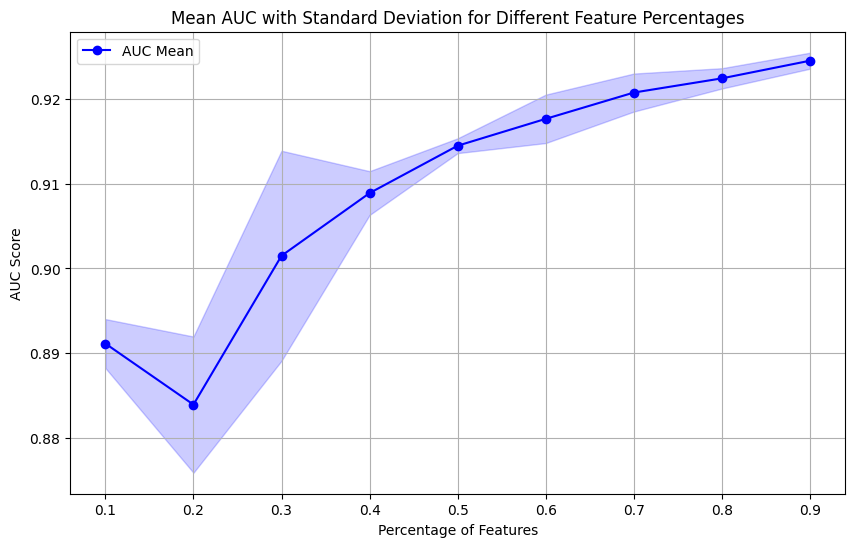

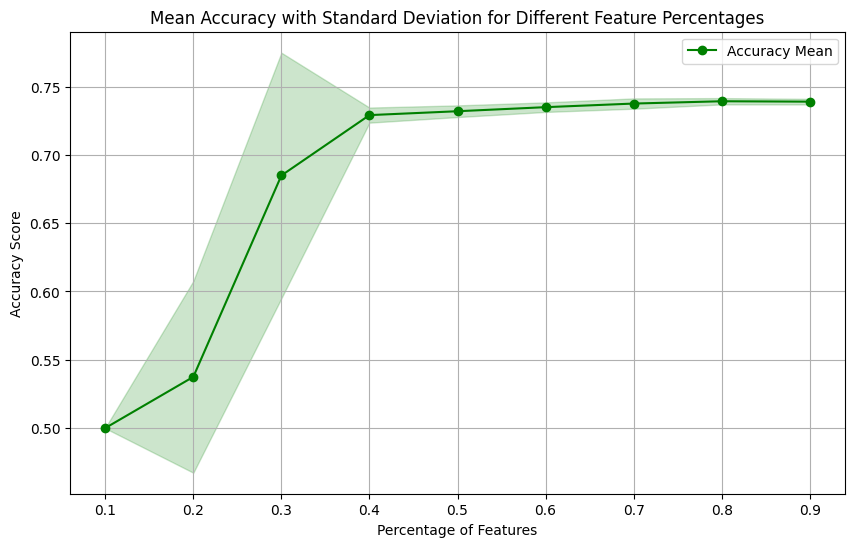

In [8]:
# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(feature_percentages, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(feature_percentages, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', alpha=0.2)  # Adjusted transparency for AUC Std
plt.xlabel('Percentage of Features')
plt.ylabel('AUC Score')
plt.title('Mean AUC with Standard Deviation for Different Feature Percentages')
plt.grid(True)
plt.legend()

# Plotting Accuracy results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(feature_percentages, test_accuracy_acc_mean, label='Accuracy Mean', color='green', marker='o')
plt.fill_between(feature_percentages, 
                 np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std),
                 np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std),
                 color='green', alpha=0.2)  # Adjusted transparency for Accuracy Std
plt.xlabel('Percentage of Features')
plt.ylabel('Accuracy Score')
plt.title('Mean Accuracy with Standard Deviation for Different Feature Percentages')
plt.grid(True)
plt.legend()


## HEAT MAP AUC AND ACC

In [23]:
def evaluate_model(hidden_channels, out_channels, epochs=300, corrupt=False, corrupt_percentage=0.1):
    # Initialize the model
    model = Net(dataset.num_features, hidden_channels, out_channels).to(device)

    # Set up the optimizer and loss function
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize the trainer with the model, optimizer, and criterion
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and evaluate
    _, _, _, final_test_auc, final_test_acc, _ = trainer.train_model(
        train_data=train_data,
        g_train=g_train,
        val_data=val_data,
        g_val=g_val,
        test_data=test_data,
        g_test=g_test,
        epochs=300
    )

    # Return detailed results
    return final_test_auc, final_test_acc

In [24]:
hidden_units = [32, 64, 128, 256]
output_units = [16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))


for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        auc, _ = evaluate_model(hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")

Epoch 1/300
Training completed in 0.0530 seconds.
Validation completed in 0.0090 seconds.
Epoch: 001, Loss: 0.6931, Train Acc: 0.5000, Val AUC: 0.8932, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0400 seconds.
Validation completed in 0.0090 seconds.
Epoch: 002, Loss: 0.6921, Train Acc: 0.5000, Val AUC: 0.8997, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0413 seconds.
Validation completed in 0.0087 seconds.
Epoch: 003, Loss: 0.6892, Train Acc: 0.5000, Val AUC: 0.9010, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0410 seconds.
Validation completed in 0.0100 seconds.
Epoch: 004, Loss: 0.6829, Train Acc: 0.5002, Val AUC: 0.9019, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0437 seconds.
Validation completed in 0.0098 seconds.
Epoch: 005, Loss: 0.6730, Train Acc: 0.5120, Val AUC: 0.9024, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0429 seconds.
Validation completed in 0.0092 seconds.
Epoch: 006, Loss: 0.6631, Train Acc: 0.6324, Val AUC: 0.9033, Val ACC:

Text(0.5, 1.0, 'AUC for different configurations of Hidden and Output Units')

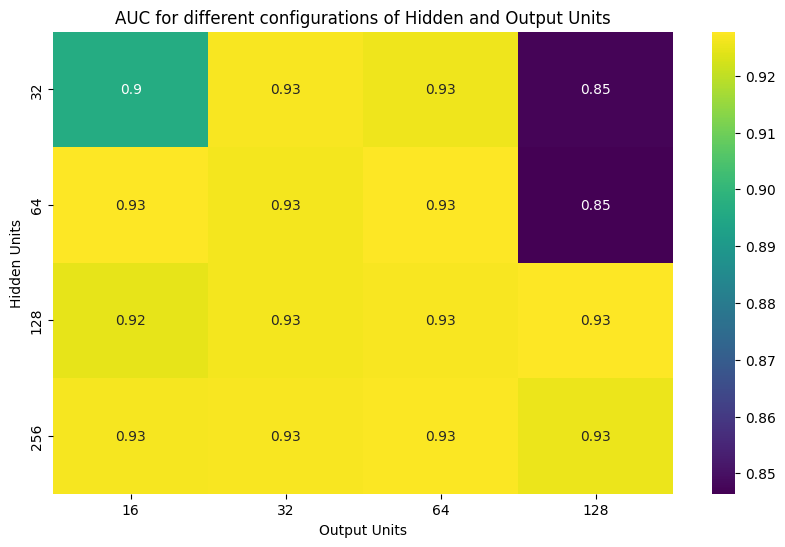

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('AUC for different configurations of Hidden and Output Units')

In [26]:
hidden_units = [32, 64, 128, 256]
output_units = [16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))


for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        _, acc = evaluate_model(hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")


Epoch 1/300
Training completed in 0.0520 seconds.
Validation completed in 0.0130 seconds.
Epoch: 001, Loss: 0.6930, Train Acc: 0.5000, Val AUC: 0.8974, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0468 seconds.
Validation completed in 0.0100 seconds.
Epoch: 002, Loss: 0.6920, Train Acc: 0.5000, Val AUC: 0.9017, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0430 seconds.
Validation completed in 0.0100 seconds.
Epoch: 003, Loss: 0.6888, Train Acc: 0.5000, Val AUC: 0.9022, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0430 seconds.
Validation completed in 0.0090 seconds.
Epoch: 004, Loss: 0.6817, Train Acc: 0.5004, Val AUC: 0.9026, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0440 seconds.
Validation completed in 0.0090 seconds.
Epoch: 005, Loss: 0.6707, Train Acc: 0.5199, Val AUC: 0.9029, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0420 seconds.
Validation completed in 0.0100 seconds.
Epoch: 006, Loss: 0.6605, Train Acc: 0.6841, Val AUC: 0.9039, Val ACC:

Text(0.5, 1.0, 'ACC for different configurations of Hidden and Output Units')

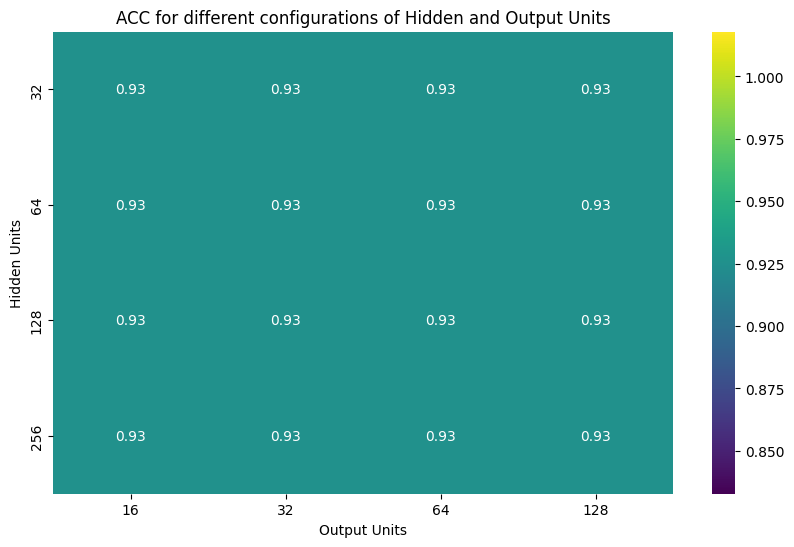

In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(results_matrix, annot=True, xticklabels=output_units, yticklabels=hidden_units, cmap='viridis')
plt.xlabel('Output Units')
plt.ylabel('Hidden Units')
plt.title('ACC for different configurations of Hidden and Output Units')

## HEAT MAP LEARNING RATE

In [28]:
# Function to evaluate the model with a given learning rate using the trainer class
def evaluate_model(learning_rate):
    model = Net(dataset.num_features, 128, 64).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize the trainer
    trainer = GCNTrainer(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, final_test_auc, final_test_acc, _ = trainer.train_model(
        train_data=train_data,
        g_train=g_train,
        val_data=val_data,
        g_val=g_val,
        test_data=test_data,
        g_test=g_test,
        epochs=300
    )

    return final_test_auc, final_test_acc 

In [29]:
# Define learning rates to evaluate
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
results_matrix = np.zeros((len(learning_rates), 2)) 

# Evaluate the model for different learning rates
for i, lr in enumerate(learning_rates):
    auc, acc = evaluate_model(lr)
    results_matrix[i, 0] = auc  # AUC
    results_matrix[i, 1] = acc  # Accuracy
    print(f"Learning rate: {lr} -> AUC: {auc:.4f}, Accuracy: {acc:.4f}")

Epoch 1/300
Training completed in 0.0790 seconds.
Validation completed in 0.0200 seconds.
Epoch: 001, Loss: 0.6928, Train Acc: 0.5000, Val AUC: 0.9131, Val ACC: 0.5000
Epoch 2/300
Training completed in 0.0685 seconds.
Validation completed in 0.0200 seconds.
Epoch: 002, Loss: 0.6926, Train Acc: 0.5000, Val AUC: 0.9129, Val ACC: 0.5000
Epoch 3/300
Training completed in 0.0683 seconds.
Validation completed in 0.0190 seconds.
Epoch: 003, Loss: 0.6924, Train Acc: 0.5000, Val AUC: 0.9127, Val ACC: 0.5000
Epoch 4/300
Training completed in 0.0685 seconds.
Validation completed in 0.0190 seconds.
Epoch: 004, Loss: 0.6921, Train Acc: 0.5000, Val AUC: 0.9121, Val ACC: 0.5000
Epoch 5/300
Training completed in 0.0706 seconds.
Validation completed in 0.0190 seconds.
Epoch: 005, Loss: 0.6916, Train Acc: 0.5000, Val AUC: 0.9114, Val ACC: 0.5000
Epoch 6/300
Training completed in 0.0718 seconds.
Validation completed in 0.0190 seconds.
Epoch: 006, Loss: 0.6911, Train Acc: 0.5000, Val AUC: 0.9105, Val ACC:

Text(120.72222222222221, 0.5, 'Learning Rate')

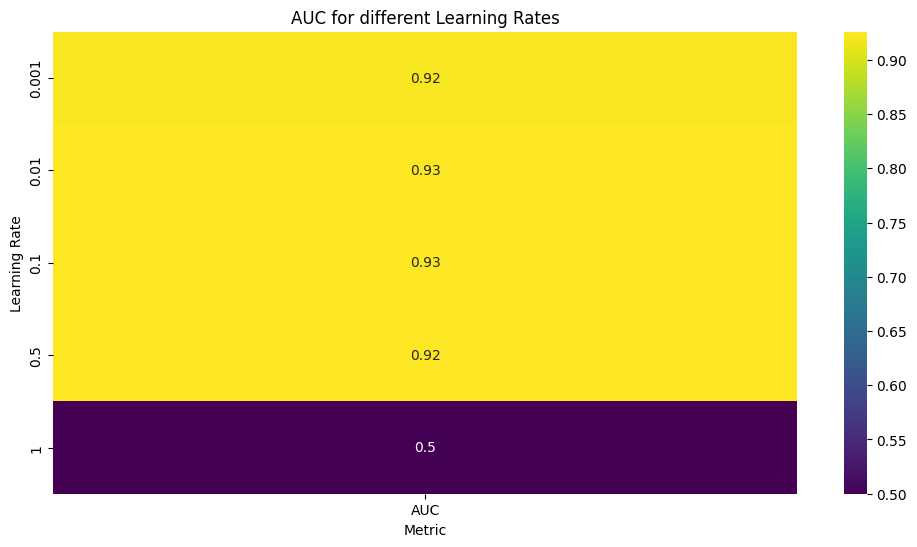

In [30]:
# Plot AUC results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 0].reshape(-1, 1), annot=True, xticklabels=['AUC'], yticklabels=learning_rates, cmap='viridis')
plt.title('AUC for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

Text(120.72222222222221, 0.5, 'Learning Rate')

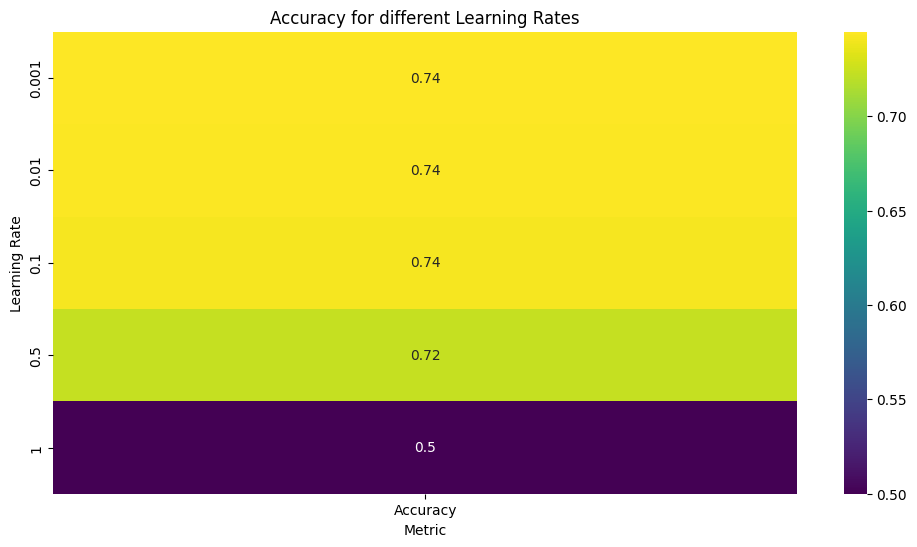

In [31]:
# Plot Accuracy results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 1].reshape(-1, 1), annot=True, xticklabels=['Accuracy'], yticklabels=learning_rates, cmap='viridis')
plt.title('Accuracy for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')